# TOPIC MODELLING

In [32]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
import re
import string
import numpy as np
from gensim import models,corpora
import nltk
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
#loading dataset
df=pd.read_excel('/content/PMO translated Cleaned data.xlsx')
df.head()

,Survey Answer ID,Q10\nIs there anything else you would like to share with us?,Q11 translated,Q11\nno-translated
0,f91da0c6-602e-40b0-a96e-aef7469e6ebb,Compliments,thanks,thanks
1,3a836d06-fb1c-41a6-99aa-39202beb281c,Comment on the Service,good,good
2,7f6a288d-d2db-42df-9ee2-aba2b0a782ca,Comment on the Service,NICE SERVICES,NICE SERVICESS
3,c3e1f8d4-2956-4734-9571-6c31656484be,Comment on the Service,page response is unstable. rest is all fine,page respsonse is unstable. rest is all fine
4,a3d6ce90-d5e4-4214-8f14-3899d34e8980,Comment on the Service,THANKS,THANKS


In [34]:
df.shape

(29220, 4)

In [35]:
df.columns

Index(['Survey Answer ID',
       'Q10\nIs there anything else you would like to share with us?',
       'Q11 translated', 'Q11\nno-translated'],
      dtype='object')

In [36]:
### dropping unnecessary columns (id and no translated)
df = df.drop(['Survey Answer ID', 'Q10\nIs there anything else you would like to share with us?', 'Q11\nno-translated'], axis=1)
df.head()

,Q11 translated
0,thanks
1,good
2,NICE SERVICES
3,page response is unstable. rest is all fine
4,THANKS


In [37]:
# renaming the column
df.rename(columns = {'Q11 translated': 'text'}, inplace = True)
df.head()

,text
0,thanks
1,good
2,NICE SERVICES
3,page response is unstable. rest is all fine
4,THANKS


### DATA PREPROCESSING AND EDA

In [38]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)

    #remove more than 15 characters
    text = re.sub(r'\b\w{16,}\b', '', text)
    
    return text

In [39]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,text,clean_text
0,thanks,thanks
1,good,good
2,NICE SERVICES,NICE SERVICES
3,page response is unstable. rest is all fine,page response is unstable rest is all fine
4,THANKS,THANKS
5,thanks,thanks
6,System error message,System error message
7,Good,Good
8,page response is unstable. rest is all fine,page response is unstable rest is all fine
9,VERY GOOD AND WE ARE HAPPY KEEP THE GOOD THING GOING GOOD DAY,VERY GOOD AND WE ARE HAPPY KEEP THE GOOD THING GOING GOOD DAY


In [40]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [41]:
# renaming the column
df.rename(columns = {'clean_text':'text'}, inplace = True)
df.head()

,text
0,thanks
1,good
2,NICE SERVICES
3,page response is unstable rest is all fine
4,THANKS


In [42]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [43]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in sw_nltk]
  #review = [wnl.lemmatize(word) for word in review if word not in sw_spacy]
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [44]:
df['text']=df['text'].apply(clean_text)
df.head()

,text
0,thanks
1,good
2,nice service
3,page response unstable rest fine
4,thanks


In [45]:
# function to remove names
def remove_names(text):
    # define regular expression pattern to match names
    pattern = re.compile(r'\b(?:abd|abdouli|abdul|abdulaziz|adel|abdullah|abdulrahman|abrar|abeer|abi|adn|adu|ahmad|ahmed|ahood|aht|alabdooli|alabdouli|alachram|alaghbari|alc|alhamdulillah|alhamoor|ali|alia|alif|alkindi|allah|allhumdulliah|allo|alqubaisi|alsalaam|alsoor|alykom|amal|amata|amed|amen|amer|amis|ammar|amoudi|amra|amsat|amwal|ana|andrew|anf|anz|aqsa|atta|atleat|asharj|ashkram|asif|asim|asma|asmaa|awael|awatef|ayash|ayisha|ayman|azhar|azza|badr|badria|badriya|bahia|bakr|balakrishnan|balooshi|balushi|baniyas|bara|baraem|barsh|bastaki|batayneh|bilal|bint|biyyat|brian|bthe|budaiwi|issy|ive|jaddaf|jafar|jafiliya|jahili|jalal|jamal||janan|janoubi|jasmine|jassim|jazak|jazeera|jebel|jeel|jihadjoseline|juma|jumaia|jvc|kalba|kalban|kareem|katyn|kawkaba|keji|kenneth|khabisi|khaili|khaimah|khair|khalaf|khaled|khalid|khalifa|khamis|kharma|khatib|khatm|khattab|khazna|khor|khorfakkan|kjhgfds|kkk|kmz|konain|kumz|kutty|kvito|kyrgyz|dadsad|sddaddad|sdsds||sha|shaer|shafei|shah|shahama|shakhbout|shama|shamikha|shamkha|shamsa|shamsi|shanahan|sharifa|sharq|shatha|shawamekh|shd|shefaa|shehhi|sheikh|sheikha|shiva|shkran|soo|sooo|soooo|sooooo|soooooo|soumya|sadsadsad|sssasss|suhail|suhaila|suhair|sukkah|szhp|taha|tahaluf|taharba|umm|umrah|xia|yabladi|yas|yasmine|yassin|yousef|youssef|youssefni|ypu|yuen|zaabi|zahir|zakher|zaki|zarooni|zakat|zayed|zina|zindabad|ziyad|zubaida|zuhair)\b', re.IGNORECASE)
    return re.sub(pattern, '', text)

# apply the function to the text column
df['text'] = df['text'].apply(remove_names)

In [46]:
# function to remove places
def replace_places(text):
    # define regular expression pattern to match places
    pattern = re.compile(r'\b(?:abu dhabi|abu|dhabi)\b', re.IGNORECASE)
    
    return re.sub(pattern, 'abudhabi', text)

# apply the function to the text column
df['text'] = df['text'].apply(replace_places)

In [47]:
# function to remove places
def replace_places(text):
    # define regular expression pattern to match places
    
    pattern = re.compile(r'\b(?:thank|thankyou)\b', re.IGNORECASE)
    
    return re.sub(pattern, 'thanks', text)

# apply the function to the text column
df['text'] = df['text'].apply(replace_places)

In [48]:
# removing single characters after cleaning the sentence
df['text'] = df['text'].str.replace(r'\b\w{1,2}\b', '', regex=True)
df.head()

,text
0,thanks
1,good
2,nice service
3,page response unstable rest fine
4,thanks


In [49]:
# Remove empty rows
df = df[df['text'].apply(lambda x: len(x) > 0)]
df.head()

,text
0,thanks
1,good
2,nice service
3,page response unstable rest fine
4,thanks


In [50]:
df.reset_index(inplace=True)

In [51]:
df['text'][16]

'thanks'

In [52]:
df.shape

(26609, 2)

In [53]:
# tokenization and find the frequency
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
t=[]
for i in range(len(df['text'])):
    tokenized_text=sent_tokenize(df['text'][i])
    tokenized_word=word_tokenize(df['text'][i])
    t =t+tokenized_word
#print(t)
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
print(freq)
fdist = FreqDist(t)
print(fdist)

thanks         10759
good            5766
service         3560
excellent       1676
much            1160
please          1024
application      830
time             732
easy             683
effort           673
dtype: int64
<FreqDist with 4941 samples and 91045 outcomes>


### Top 10 words

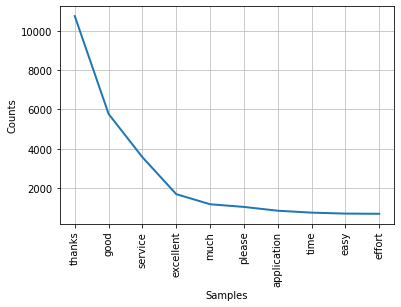

In [54]:
import matplotlib.pyplot as plt

fdist.plot(10,cumulative=False)

plt.show()

### Top five words

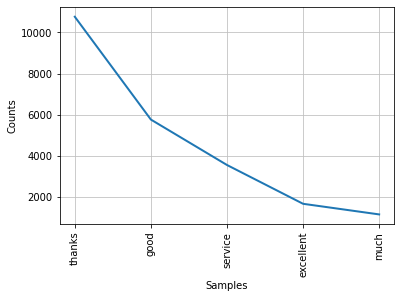

In [55]:
import matplotlib.pyplot as plt

fdist.plot(5,cumulative=False)

plt.show()

In [56]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

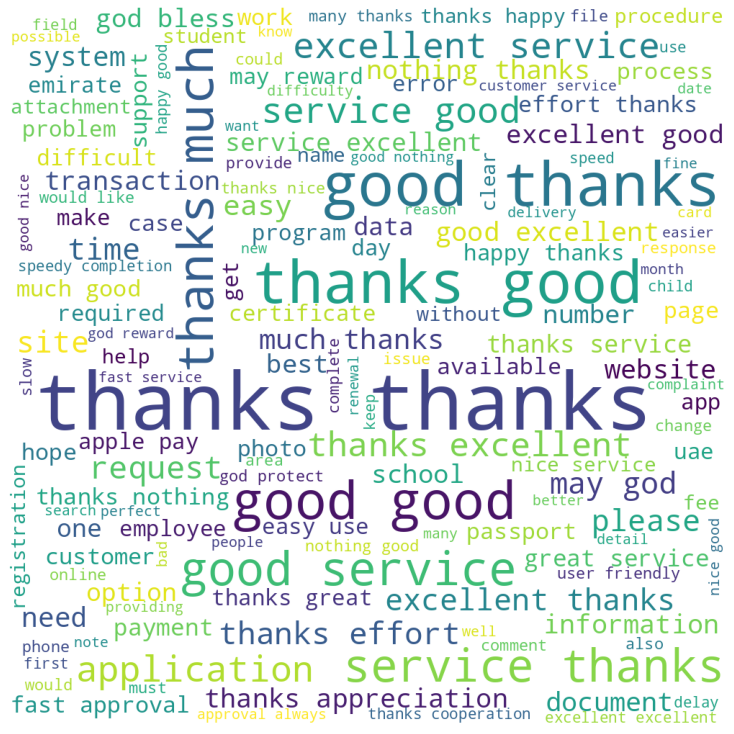

In [57]:
#WORD CLOUD
from wordcloud import WordCloud
comment_words = ' '
for words in t: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color='white' , 
                stopwords = stop, 
                min_font_size = 20).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (20, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)